In [185]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1700510212.5734384
Mon Nov 20 19:56:52 2023


How to approximate a classical kernel with a quantum computer {#classical_kernels}
=============================================================

::: {.meta}
:property=\"og:description\": Finding a QK to approximate the Gaussian
kernel. :property=\"og:image\":
<https://pennylane.ai/qml/_images/toy_qek.png>
:::

::: {.related}
tutorial\_kernels\_module Training and evaluating quantum kernels
tutorial\_kernel\_based\_training Kernel-based training of quantum
models with scikit-learn tutorial\_expressivity\_fourier\_series Quantum
models as Fourier series
:::

*Author: Elies Gil-Fuster (Xanadu Resident) --- Posted: 01 Mar 2022.
Last updated: 02 March 2022*

Forget about advantages, supremacies, or speed-ups. Let us understand
better what we can and cannot do with a quantum computer. More
specifically, in this demo, we want to look into quantum kernels and ask
whether we can replicate classical kernel functions with a quantum
computer. Lots of researchers have lengthily stared at the opposite
question, namely that of classical simulation of quantum algorithms.
Yet, by studying what classes of functions we can realize with quantum
kernels, we can gain some insight into their inner workings.

Usually, in quantum machine learning (QML), we use parametrized quantum
circuits (PQCs) to find good functions, whatever *good* means here.
Since kernels are just one specific kind of well-defined functions, the
task of finding a quantum kernel (QK) that approximates a given
classical one could be posed as an optimization problem. One way to
attack this task is to define a loss function quantifying the distance
between both functions (the classical kernel function and the PQC-based
hypothesis). This sort of approach does not help us much to gain
theoretical insights about the structure of kernel-emulating quantum
circuits, though.

In order to build intuition, we will instead study the link between
classical and quantum kernels through the lens of the Fourier
representation of a kernel, which is a common tool in classical machine
learning. Two functions can only have the same Fourier spectrum if they
are the same function. It turns out that, for certain classes of quantum
circuits, [we can theoretically describe the Fourier spectrum rather
well](https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html).

Using this theory, together with some good old-fashioned convex
optimization, we will derive a quantum circuit that approximates the
famous Gaussian kernel.

In order to keep the demo short and sweet, we focus on one simple
example. The same ideas apply to more general scenarios. Also, Refs.,,
and should be helpful for those who\'d like to see the underlying theory
of QKs (and also so-called *Quantum Embedding Kernels*) and their
Fourier representation. So tag along if you\'d like to see how we build
a quantum kernel that approximates the well-known Gaussian kernel
function!

|

![Schematic of the steps covered in this
demo.](../demonstrations/classical_kernels/classical_kernels_flow_chart.png){.align-center
width="60.0%"}

Kernel-based Machine Learning
-----------------------------

We will not be reviewing all the notions of kernels in-depth here.
Instead, we only need to know that an entire branch of machine learning
revolves around some functions we call kernels. If you\'d like to learn
more about where these functions come from, why they\'re important, and
how we can use them (e.g. with PennyLane), check out the following
demos, which cover different aspects extensively:

1.  [Training and evaluating quantum
    kernels](https://pennylane.ai/qml/demos/tutorial_kernels_module.html)
2.  [Kernel-based training of quantum models with
    scikit-learn](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html)

For the purposes of this demo, a *kernel* is a real-valued function of
two variables $k(x_1,x_2)$ from a given data domain $x_1,
x_2\in\mathcal{X}$. In this demo, we\'ll deal with real vector spaces as
the data domain $\mathcal{X}\subseteq\mathbb{R}^d$, of some dimension
$d$. A kernel has to be symmetric with respect to exchanging both
variables $k(x_1,x_2) = k(x_2,x_1)$. We also enforce kernels to be
positive semi-definite, but let\'s avoid getting lost in mathematical
lingo. You can trust that all kernels featured in this demo are positive
semi-definite.

Shift-invariant kernels
-----------------------

Some kernels fulfill another important restriction, called
*shift-invariance*. Shift-invariant kernels are those whose value
doesn\'t change if we add a shift to both inputs. Explicitly, for any
suitable shift vector $\zeta\in\mathcal{X}$, shift-invariant kernels are
those for which $k(x_1+\zeta,x_2+\zeta)=k(x_1,x_2)$ holds. Having this
property means the function can be written in terms of only one
variable, which we call the *lag vector*
$\delta:=x_1-x_2\in\mathcal{X}$. Abusing notation a bit:

$$k(x_1,x_2)=k(x_1-x_2,0) = k(\delta).$$

For shift-invariant kernels, the exchange symmetry property
$k(x_1,x_2)=k(x_2,x_1)$ translates into reflection symmetry
$k(\delta)=k(-\delta)$. Accordingly, we say $k$ is an *even function*.

Warm up: Implementing the Gaussian kernel
-----------------------------------------

First, let\'s introduce a simple classical kernel that we will
approximate on the quantum computer. Start importing the usual suspects:


In [186]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(53173)

We\'ll look at the Gaussian kernel:
$k_\sigma(x_1,x_2):=e^{-\lVert x_1-x_2\rVert^2/2\sigma^2}$. This
function is clearly shift-invariant:

$$\begin{aligned}
k_\sigma(x_1+\zeta,x_2+\zeta) &= e^{-\lVert(x_1+\zeta)-(x_2+\zeta)\rVert^2/2\sigma^2} \\
& = e^{-\lVert x_1-x_2\rVert^2/2\sigma^2} \\
& = k_\sigma(x_1,x_2).
\end{aligned}$$

The object of our study will be a simple version of the Gaussian kernel,
where we consider $1$-dimensional data, so $\lVert
x_1-x_2\rVert^2=(x_1-x_2)^2$. Also, we take $\sigma=1/\sqrt{2}$ so that
we further simplify the exponent. We can always re-introduce it later by
rescaling the data. Again, we can write the function in terms of the lag
vector only:

$$k(\delta)=e^{-\delta^2}.$$

Now let\'s write a few lines to plot the Gaussian kernel:


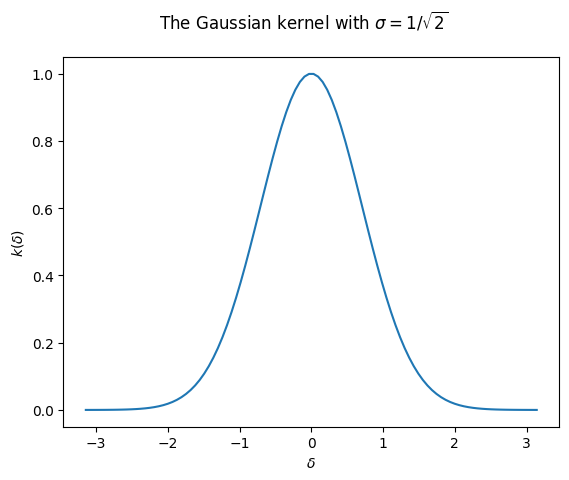

In [187]:
def gaussian_kernel(delta):
    return math.exp(-delta ** 2)

def make_data(n_samples, lower=-np.pi, higher=np.pi):
    x = np.linspace(lower, higher, n_samples)
    y = np.array([gaussian_kernel(x_) for x_ in x])
    return x,y

X, Y_gaussian = make_data(100)

plt.plot(X, Y_gaussian)
plt.suptitle("The Gaussian kernel with $\sigma=1/\sqrt{2}$")
plt.xlabel("$\delta$")
plt.ylabel("$k(\delta)$")
plt.show();

In this demo, we will consider only this one example. However, the
arguments we make and the code we use are also amenable to any kernel
with the following mild restrictions:

1.  Shift-invariance
2.  Normalization $k(0)=1$.
3.  Smoothness (in the sense of a quickly decaying Fourier spectrum).

Note that is a very large class of kernels! And also an important one
for practical applications.

Fourier analysis of the Gaussian kernel
=======================================

The next step will be to find the Fourier spectrum of the Gaussian
kernel, which is an easy problem for classical computers. Once we\'ve
found it, we\'ll build a QK that produces a finite Fourier series
approximation to that spectrum.

Let\'s briefly recall that a Fourier series is the representation of a
periodic function using the sine and cosine functions. Fourier analysis
tells us that we can write any given periodic function as

$$f(x) = a_0 + \sum_{n=1}^\infty a_n\cos(n\omega_0x) + b_n\sin(n\omega_0x).$$

For that, we only need to find the suitable base frequency $\omega_0$
and coefficients $a_0, a_1, \ldots, b_0, b_1,\ldots$.

But the Gaussian kernel is an aperiodic function, whereas the Fourier
series only makes sense for periodic functions!

*What can we do?!*

We can cook up a periodic extension to the Gaussian kernel, for a given
period $2L$ (we take $L=\pi$ as default):


In [188]:
def Gauss_p(x, L=np.pi):
    # Send x to x_mod in the period around 0
    x_mod = np.mod(x+L, 2*L) - L
    return gaussian_kernel(x_mod)

which we can now plot


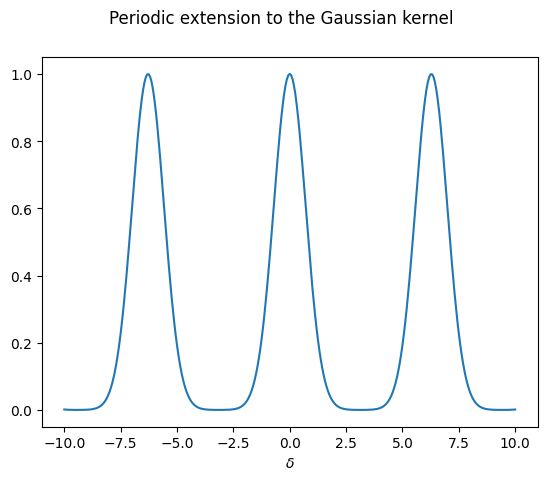

In [189]:
x_func = np.linspace(-10, 10, 321)
y_func = [Gauss_p(x) for x in x_func]

plt.plot(x_func, y_func)
plt.xlabel("$\delta$")
plt.suptitle("Periodic extension to the Gaussian kernel")
plt.show();

In practice, we would construct several periodic extensions of the
aperiodic function, with increasing periods. This way, we can study the
behaviour when the period approaches infinity, i.e. the regime where the
function stops being periodic.

Next up, how does the Fourier spectrum of such an object look like? We
can find out using PennyLane\'s `fourier` module!


In [190]:
from pennylane.fourier import coefficients

The function `coefficients` computes for us the coefficients of the
Fourier series up to a fixed term. One tiny detail here: `coefficients`
returns one complex number $c_n$ for each frequency $n$. The real part
corresponds to the $a_n$ coefficient, and the imaginary part to the
$b_n$ coefficient: $c_n=a_n+ib_n$. Because the Gaussian kernel is an
even function, we know that the imaginary part of every coefficient will
be zero, so $c_n=a_n$.


In [191]:
def fourier_p(d):
    """
    We only take the first d coefficients [:d]
    because coefficients() treats the negative frequencies
    as different from the positive ones.
    For real functions, they are the same.
    """
    return np.real(coefficients(Gauss_p, 1, d-1)[:d])

We are restricted to considering only a finite number of Fourier terms.
But isn\'t that problematic, one may say? Well, maybe. Since we know the
Gaussian kernel is a smooth function, we expect that the coefficients
converge to $0$ at some point, and we will only need to consider terms
up to this point. Let\'s look at the coefficients we obtain by setting a
low value for the number of coefficients and then slowly letting it
grow:


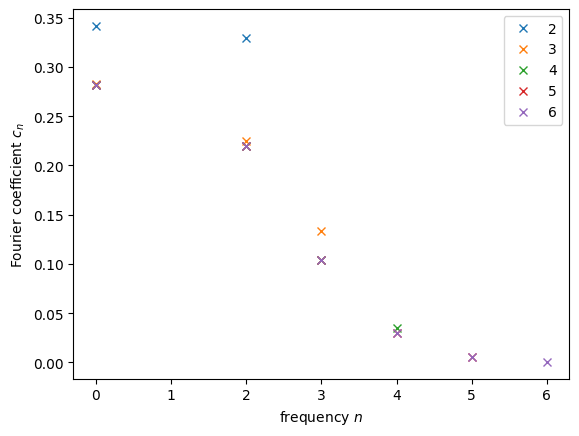

In [192]:
N = [0]
for n in range(2,7):
    N.append(n)
    F = fourier_p(n)
    plt.plot(N, F, 'x', label='{}'.format(n))

plt.legend()
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient $c_n$")
plt.show();

What do we see? For very small coefficient counts, like $2$ and $3$, we
see that the last allowed coefficient is still far from $0$. That\'s a
very clear indicator that we need to consider more frequencies. At the
same time, it seems like starting at $5$ or $6$ all the non-zero
contributions have already been well captured. This is important for us,
since it tells us the minimum number of qubits we should use. One can
see that every new qubit doubles the number of frequencies we can use,
so for $n$ qubits, we will have $2^n$. At minimum of $6$ frequencies
means at least $3$ qubits, corresponding to $2^3=8$ frequencies. As
we\'ll see later, we\'ll work with $5$ qubits, so $32$ frequencies. That
means the spectrum we will be trying to replicate will be the following:


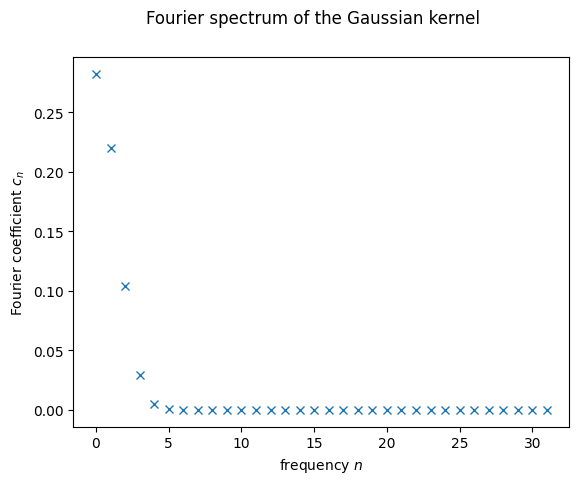

In [193]:
plt.plot(range(32), fourier_p(32), 'x')
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient $c_n$")
plt.suptitle("Fourier spectrum of the Gaussian kernel")
plt.show();

We just need a QK with the same Fourier spectrum!

Designing a suitable QK
=======================

Designing a suitable QK amounts to designing a suitable parametrized
quantum circuit. Let\'s take a moment to refresh the big scheme of
things with the following picture:

|

![The quantum kernel considered in this
demo.](../demonstrations/classical_kernels/QEK.jpg){.align-center
width="70.0%"}

We construct the quantum kernel from a quantum embedding (see the demo
on [Quantum Embedding
Kernels](pennylane.ai/qml/demos/tutorial_kernels_module.html)). The
quantum embedding circuit will consist of two parts. The first one,
trainable, will be a parametrized general state preparation scheme
$W_a$, with parameters $a$. In the second one, we input the data,
denoted by $S(x)$.

Start with the non-trainable gate we\'ll use to encode the data $S(x)$.
It consists of applying one Pauli-$Z$ rotation to each qubit with
rotation parameter $x$ times some constant $\vartheta_i$, for the
$i^\text{th}$ qubit.


In [194]:
def S(x, thetas, wires):
    for (i, wire) in enumerate(wires):
        qml.RZ(thetas[i] * x, wires = [wire])

By setting the `thetas` properly, we achieve the integer-valued
spectrum, as required by the Fourier series expansion of a function of
period $2\pi$: $\{0, 1, \ldots, 2^n-2, 2^n-1\}$, for $n$ qubits. Some
math shows that setting $\vartheta_i=2^{n-i}$, for $\{1,\ldots,n\}$
produces the desired outcome.


In [195]:
def make_thetas(n_wires):
    return [2 ** i for i in range(n_wires-1, -1, -1)]

Next, we introduce the only trainable gate we need to make use of.
Contrary to the usual Ansätze used in supervised and unsupervised
learning, we use a state preparation template called
`MottonenStatePreparation`. This is one option for amplitude encoding
already implemented in PennyLane, so we don\'t need to code it
ourselves. Amplitude encoding is a common way of embedding classical
data into a quantum system in QML. The unitary associated to this
template transforms the $\lvert0\rangle$ state into a state with
amplitudes $a=(a_0,a_1,\ldots,a_{2^n-1})$, namely
$\lvert a\rangle=\sum_j a_j\lvert j\rangle$, provided
$\lVert a\rVert^2=1$.


In [196]:
def W(features, wires):
    qml.templates.state_preparations.MottonenStatePreparation(features, wires)

With that, we have the feature map onto the Hilbert space of the quantum
computer:

$$\lvert x_a\rangle = S(x)W_a\lvert0\rangle,$$

for a given $a$, which we will specify later.

Accordingly, we can build the QK corresponding to this feature map as

$$\begin{aligned}
k_a(x_1,x_2) &= \lvert\langle0\rvert W_a^\dagger S^\dagger(x_1)
S(x_2)W_a\lvert0\rangle\rvert^2 \\
&= \lvert\langle0\rvert W_a^\dagger S(x_2-x_1) W_a\lvert0\rangle\rvert^2.
\end{aligned}$$

In the code below, the variable `amplitudes` corresponds to our set $a$.


In [197]:
def ansatz(x1, x2, thetas, amplitudes, wires):
    W(amplitudes, wires)
    S(x1 - x2, thetas, wires)
    qml.adjoint(W)(amplitudes, wires)

Since this kernel is by construction real-valued, we also have

$$\begin{aligned}
(k_a(x_1,x_2))^\ast &= k_a(x_1,x_2) \\
&= \lvert\langle0\rvert W_a^\dagger S(x_1-x_2) W_a\lvert0\rangle\rvert^2 \\
&= k_a(x_2,x_1).
\end{aligned}$$

Further, this QK is also shift-invariant $k_a(x_1,x_2) = k_a(x_1+\zeta,
x_2+\zeta)$ for any $\zeta\in\mathbb{R}$. So we can also write it in
terms of the lag $\delta=x_1-x_2$:

$$k_a(\delta) = \lvert\langle0\rvert W_a^\dagger
S(\delta)W_a\lvert0\rangle\rvert^2.$$

So far, we only wrote the gate layout for the quantum circuit, no
measurement! We need a few more functions for that!

Computing the QK function on a quantum device
=============================================

Also, at this point, we need to set the number of qubits of our
computer. For this example, we\'ll use the variable `n_wires`, and set
it to $5$.


In [198]:
n_wires = 7

We initialize the quantum simulator:


In [199]:
dev = qml.device("lightning.qubit", wires = n_wires, shots = None)

Next, we construct the quantum node:


In [200]:
@qml.qnode(dev, interface="autograd", expansion_strategy='device')
def QK_circuit(x1, x2, thetas, amplitudes):
    ansatz(x1, x2, thetas, amplitudes, wires = range(n_wires))
    return qml.probs(wires = range(n_wires))

Recall that the output of a QK is defined as the probability of
obtaining the outcome $\lvert0\rangle$ when measuring in the
computational basis. That corresponds to the $0^\text{th}$ entry of
`qml.probs`:


In [201]:
def QK_2(x1, x2, thetas, amplitudes):
    return QK_circuit(x1, x2, thetas, amplitudes)[0]

As a couple of quality-of-life improvements, we write a function that
implements the QK with the lag $\delta$ as its argument, and one that
implements it on a given set of data:


In [202]:
def QK(delta, thetas, amplitudes):
    return QK_2(delta, 0, thetas, amplitudes)

def QK_on_dataset(deltas, thetas, amplitudes):
    y = np.array([QK(delta, thetas, amplitudes) for delta in deltas])
    return y

This is also a good place to fix the `thetas` array, so that we don\'t
forget later.


In [203]:
thetas = make_thetas(n_wires)

Let\'s see how this looks like for one particular choice of
`amplitudes`. We need to make sure the array fulfills the normalization
conditions.


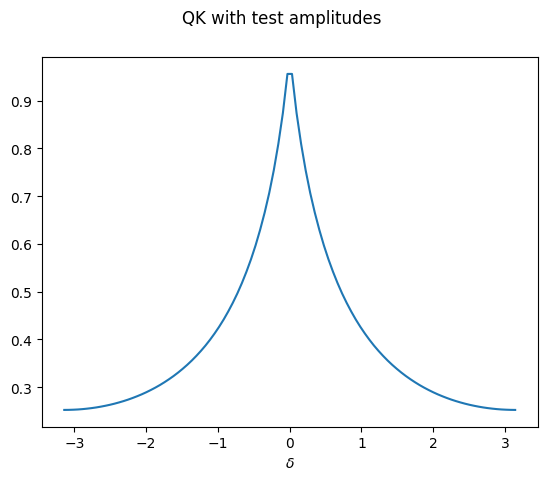

In [204]:
test_features = np.asarray([1./(1+i) for i in range(2 ** n_wires)])
test_amplitudes = test_features / np.sqrt(np.sum(test_features ** 2))

Y_test = QK_on_dataset(X, thetas, test_amplitudes)

plt.plot(X, Y_test)
plt.xlabel("$\delta$")
plt.suptitle("QK with test amplitudes")
plt.show();

One can see that the stationary kernel with this particular initial
state has a decaying spectrum that looks similar to $1/\lvert x\rvert$
--- but not yet like a Gaussian.

How to find the amplitudes emulating a Gaussian kernel
======================================================

If we knew exactly which amplitudes to choose in order to build a given
Fourier spectrum, our job would be done here. However, the equations
derived in the literature are not trivial to solve.

As mentioned in the introduction, one could just \"learn\" this
relation, that is, tune the parameters of the quantum kernel in a
gradient-based manner until it matches the classical one.

We want to take an intermediate route between analytical solution and
black-box optimization. For that, we derive an equation that links the
amplitudes to the spectrum we want to construct and then use
old-fashioned convex optimization to find the solution. If you are not
interested in the details, you can just jump to the last plots of this
demo and confirm that we can to emulate the Gaussian kernel using the
ansatz for our QK constructed above.

In order to simplify the formulas, we introduce new variables, which we
call `probabilities` $(p_0, p_1, p_2, \ldots, p_{2^n-1})$, and we define
as $p_j=\lvert a_j\rvert^2$. Following the normalization property above,
we have $\sum_j p_j=1$. Don\'t get too fond of them, we only need them
for this step! Remember we introduced the vector $a$ for the
`MottonenStatePreparation` as the *amplitudes* of a quantum state? Then
it makes sense that we call its squares *probabilities*, doesn\'t it?

There is a crazy formula that matches the entries of *probabilities*
with the Fourier series of the resulting QK function:

$$\begin{aligned}
\text{probabilities} &\longrightarrow \text{Fourier coefficients} \\
\begin{pmatrix} p_0 \\ p_1 \\ p_2 \\ \vdots \\ p_{2^n-1} \end{pmatrix}
&\longmapsto \begin{pmatrix} \sum_{j=0}^{2^n-1} p_j^2 \\ \sum_{j=1}^{2^n-1}
p_j p_{j-1} \\ \sum_{j=2}^{2^n-1} p_j p_{j-2} \\ \vdots \\ p_{2^n-1} p_0
\end{pmatrix}
\end{aligned}$$

This looks a bit scary, it follows from expanding the matrix product
$W_a^\dagger S(\delta)W_a$, and then collecting terms according to
Fourier basis monomials. In this sense, the formula is general and it
applies to any shift-invariant kernel we might want to approximate, not
only the Gaussian kernel.

Our goal is to find the set of $p_j$\'s that produces the Fourier
coefficients of a given kernel function (in our case, the Gaussian
kernel), namely its spectrum $(s_0, s_1, s_2, \ldots, s_{2^n-1})$. We
consider now a slightly different map $F_s$, for a given spectrum
$(s_0, s_1, \ldots, s_{2^n-1})$:

$$\begin{aligned}
F_s: \text{probabilities} &\longrightarrow \text{Difference between Fourier
coefficients} \\
\begin{pmatrix} p_0 \\ p_1 \\ p_2 \\ \vdots \\ p_{2^n-1} \end{pmatrix}
&\longmapsto \begin{pmatrix} \sum_{j=0}^{2^n-1} p_j^2 - s_0 \\
\sum_{j=1}^{2^n-1} p_j p_{j-1} - s_1 \\ \sum_{j=2}^{2^n-1} p_j
p_{j-2} - s_2 \\ \vdots \\ p_{2^n-1}p_0 - s_{2^n-1} \end{pmatrix}.
\end{aligned}$$

If you look at it again, you\'ll see that the zero (or solution) of this
second map $F_s$ is precisely the array of *probabilities* we are
looking for. We can write down the first map as:


In [205]:
def predict_spectrum(probabilities):
    d = len(probabilities)
    spectrum = []
    for s in range(d):
        s_ = 0

        for j in range(s, d):
            s_ += probabilities[j] * probabilities[j - s]

        spectrum.append(s_)

    # This is to make the output have the same format as
    # the output of pennylane.fourier.coefficients
    for s in range(1,d):
        spectrum.append(spectrum[d - s])

    return spectrum

And then $F_s$ is just `predict_spectrum` minus the spectrum we want to
predict:


In [206]:
def F(probabilities, spectrum):
    d = len(probabilities)
    return predict_spectrum(probabilities)[:d] - spectrum[:d]

These closed-form equations allow us to find the solution numerically,
using Newton\'s method! Newton\'s method is a classical one from convex
optimization theory. For our case, since the formula is quadratic, we
rest assured that we are within the realm of convex functions.

Finding the solution
====================

In order to use Newton\'s method we need the Jacobian of $F_s$.


In [207]:
def J_F(probabilities):
    d = len(probabilities)
    J = np.zeros(shape=(d,d))
    for i in range(d):
        for j in range(d):
            if (i + j < d):
                J[i][j] += probabilities[i + j]
            if(i - j <= 0):
                J[i][j] += probabilities[j - i]
    return J

Showing that this is indeed $\nabla F_s$ is left as an exercise for the
reader. For Newton\'s method, we also need an initial guess. Finding a
good initial guess requires some tinkering; different problems will
benefit from different ones. Here is a tame one that works for the
Gaussian kernel.


In [208]:
def make_initial_probabilities(d):
    probabilities = np.ones(d)
    deg = np.array(range(1, d + 1))
    probabilities = probabilities / deg
    return probabilities

probabilities = make_initial_probabilities(2 ** n_wires)

Recall the `spectrum` we want to match is that of the periodic extension
of the Gaussian kernel.


In [209]:
spectrum = fourier_p(2 ** n_wires)

We fix the hyperparameters for Newton\'s method:


In [210]:
d = 2 ** n_wires
max_steps = 100
tol = 1.e-20

And we\'re good to go!


In [211]:
for step in range(max_steps):
    inc = np.linalg.solve(J_F(probabilities), -F(probabilities, spectrum))
    probabilities = probabilities + inc
    if (step+1) % 10 == 0:
        print("Error norm at step {0:3}: {1}".format(step + 1,
                                               np.linalg.norm(F(probabilities,
                                                                spectrum))))
        if np.linalg.norm(F(probabilities, spectrum)) < tol:
            print("Tolerance trespassed! This is the end.")
            break

Error norm at step  10: 1.4031301813314393e-13
Error norm at step  20: 5.733133931667962e-17
Error norm at step  30: 5.73510161996048e-17
Error norm at step  40: 6.397932109907197e-17
Error norm at step  50: 2.798523095400578e-17
Error norm at step  60: 3.1798007762020274e-17
Error norm at step  70: 1.3877791732136424e-17
Error norm at step  80: 3.122502437600496e-17
Error norm at step  90: 1.1210126190319044e-16
Error norm at step 100: 6.216630411247708e-17


The tolerance we set was fairly low, one should expect good things to
come out of this. Let\'s have a look at the solution:


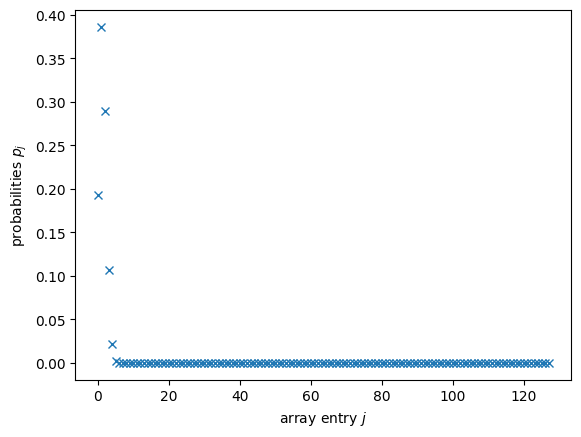

In [212]:
plt.plot(range(d), probabilities, 'x')
plt.xlabel("array entry $j$")
plt.ylabel("probabilities $p_j$")
plt.show();

Would you be able to tell whether this is correct? Me neither! But all
those probabilities being close to $0$ should make us fear some of them
must\'ve turned negative. That would be fatal for us. For
`MottonenStatePreparation`, we\'ll need to give `amplitudes` as one of
the arguments, which is the component-wise square root of
`probabilities`. And hence the problem! Even if they are very small
values, if any entry of `probabilities` is negative, the square root
will give `nan`. In order to avoid that, we use a simple thresholding
where we replace very small entries by $0$.


In [213]:
def probabilities_threshold_normalize(probabilities, thresh = 1.e-10):
    d = len(probabilities)
    p_t = probabilities.copy()
    for i in range(d):
        if np.abs(probabilities[i] < thresh):
            p_t[i] = 0.0

    p_t = p_t / np.sum(p_t)

    return p_t

Then, we need to take the square root:


In [214]:
probabilities = probabilities_threshold_normalize(probabilities)
amplitudes = np.sqrt(probabilities)

A little plotting never killed nobody


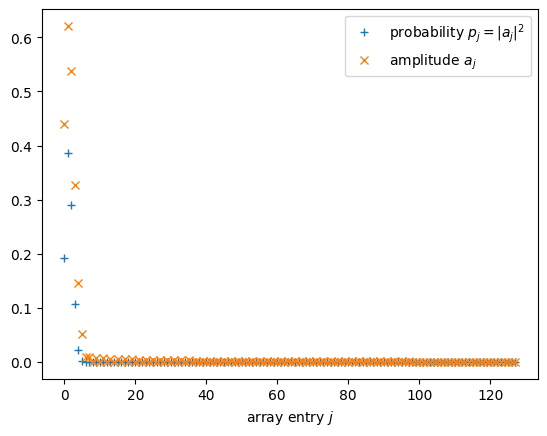

In [215]:
plt.plot(range(d), probabilities, '+', label = "probability $p_j = |a_j|^2$")
plt.plot(range(d), amplitudes, 'x', label = "amplitude $a_j$")
plt.xlabel("array entry $j$")
plt.legend()
plt.show();

Visualizing the solution
========================

And the moment of truth! Does the solution really match the spectrum? We
try it first using `predict_spectrum` only


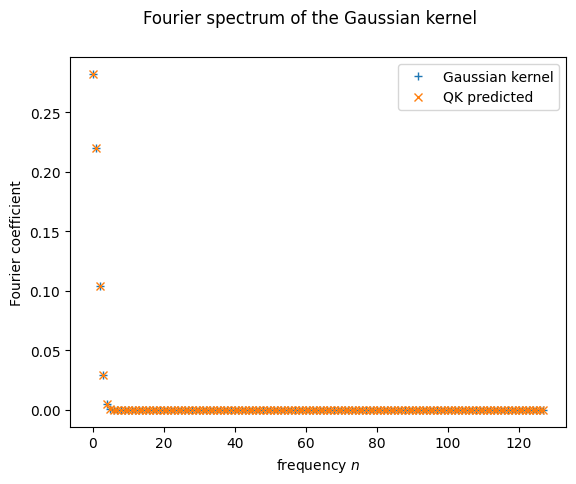

In [216]:
plt.plot(range(d), fourier_p(d)[:d], '+', label = "Gaussian kernel")
plt.plot(range(d), predict_spectrum(probabilities)[:d], 'x', label = "QK predicted")
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient")
plt.suptitle("Fourier spectrum of the Gaussian kernel")
plt.legend()
plt.show();

It seems like it does! But as we just said, this is still only the
predicted spectrum. We haven\'t called the quantum computer at all yet!

Let\'s see what happens when we call the function `coefficients` on the
QK function we defined earlier. Good coding practice tells us we should
probably turn this step into a function itself, in case it is of use
later:


In [217]:
def fourier_q(d, thetas, amplitudes):
    def QK_partial(x):
        squeezed_x = qml.math.squeeze(x)
        return QK(squeezed_x, thetas, amplitudes)
    return np.real(coefficients(QK_partial, 1, d-1))

And with this, we can finally visualize how the Fourier spectrum of the
QK function compares to that of the Gaussian kernel:


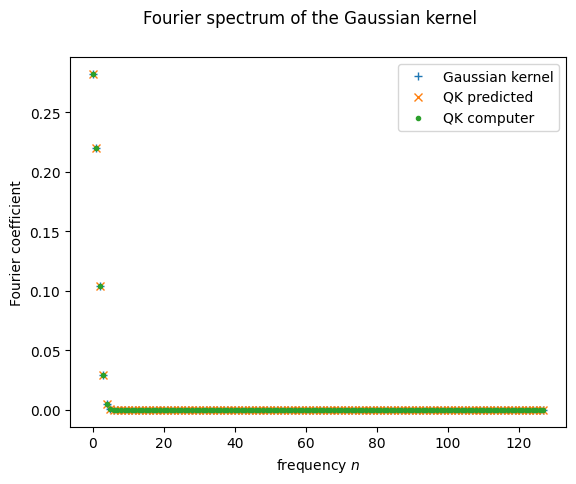

In [218]:
plt.plot(range(d), fourier_p(d)[:d], '+', label = "Gaussian kernel")
plt.plot(range(d), predict_spectrum(probabilities)[:d], 'x', label="QK predicted")
plt.plot(range(d), fourier_q(d, thetas, amplitudes)[:d], '.', label = "QK computer")
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient")
plt.suptitle("Fourier spectrum of the Gaussian kernel")
plt.legend()
plt.show();

It seems it went well! Matching spectra should mean matching kernel
functions, right?


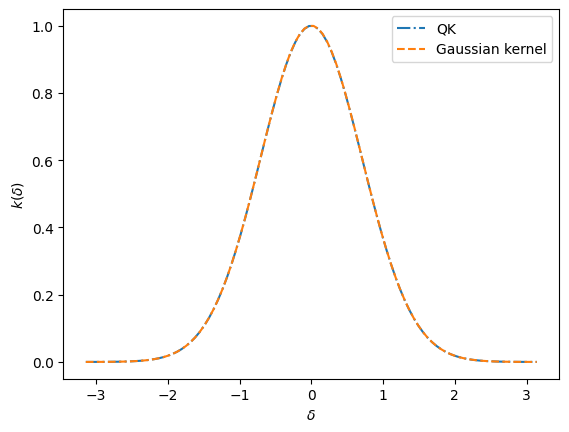

In [219]:
Y_learned = QK_on_dataset(X, thetas, amplitudes)
Y_truth = [Gauss_p(x_) for x_ in X]

plt.plot(X, Y_learned, '-.', label = "QK")
plt.plot(X, Y_truth, '--', label = "Gaussian kernel")
plt.xlabel("$\delta$")
plt.ylabel("$k(\delta)$")
plt.legend()
plt.show();

Yeah! We did it!

![](../demonstrations/classical_kernels/salesman.PNG){.align-center
width="70.0%"}

References
==========

About the author
================


In [220]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1700510369.4254823
Mon Nov 20 19:59:29 2023
